In [2]:
import pandas as pd
import quandl
import datetime

import pandas_datareader.data as web
from pandas.util.testing import assert_frame_equal

In [3]:
quandl.ApiConfig.api_key = 'VpYKj-e3pTXsUxQBMcto'


# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance)
# third is the start date, fourth is the end date

s = "AAPL"
apple = quandl.get("WIKI/" + s, start_date=start, end_date=end)
 
type(apple)


pandas.core.frame.DataFrame

In [4]:
apple.head()

Open     High     Low   Close      Volume  Ex-Dividend  \
Date                                                                   
2016-01-04  102.61  105.368  102.00  105.35  67649387.0          0.0   
2016-01-05  105.75  105.850  102.41  102.71  55790992.0          0.0   
2016-01-06  100.56  102.370   99.87  100.70  68457388.0          0.0   
2016-01-07   98.68  100.130   96.43   96.45  81094428.0          0.0   
2016-01-08   98.55   99.110   96.76   96.96  70798016.0          0.0   

            Split Ratio   Adj. Open   Adj. High   Adj. Low  Adj. Close  \
Date                                                                     
2016-01-04          1.0   99.136516  101.801154  98.547165  101.783763   
2016-01-05          1.0  102.170223  102.266838  98.943286   99.233131   
2016-01-06          1.0   97.155911   98.904640  96.489269   97.291172   
2016-01-07          1.0   95.339552   96.740467  93.165717   93.185040   
2016-01-08          1.0   95.213952   95.754996  93.484546   93.677776   

            Adj. Volume  
Date                     
2016-01-04   67649387.0  
2016-01-05   55790992.0  
2016-01-06   68457388.0  
2016-01-07   81094428.0  
2016-01-08   70798016.0

Populating the interactive namespace from numpy and matplotlib


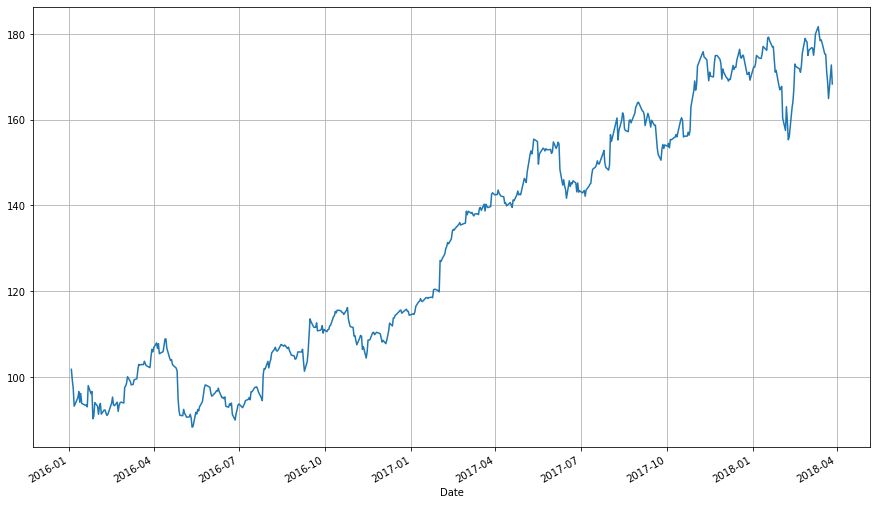

In [5]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj. Close"].plot(grid = True) # Plot the adjusted closing price of AAPL


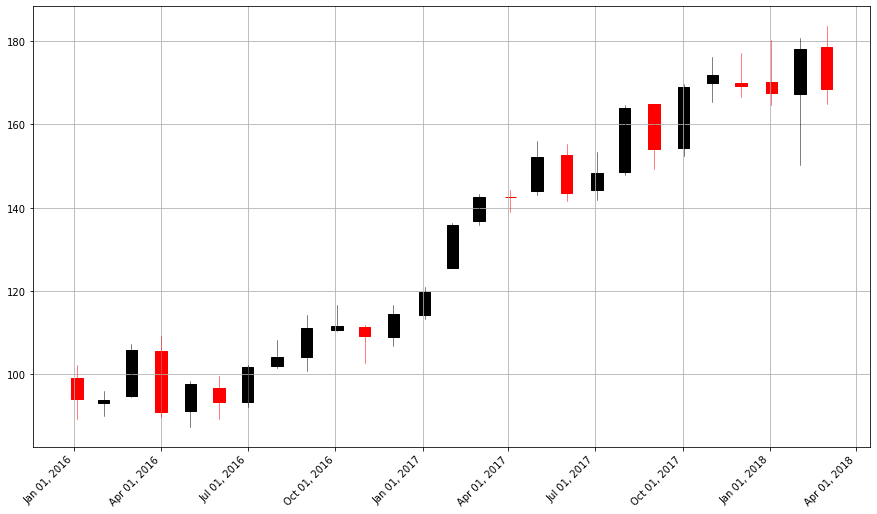

In [7]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
    
pandas_candlestick_ohlc(apple, adj=True, stick="month")

With a candlestick chart, a black candlestick indicates a day where the closing price was higher than the open (a gain), while a red candlestick indicates a day where the open was higher than the close (a loss). The wicks indicate the high and the low, and the body the open and close (hue is used to determine which end of the body is the open and which the close). Candlestick charts are popular in finance and some strategies in technical analysis use them to make trading decisions, depending on the shape, color, and position of the candles. I will not cover such strategies today.

We may wish to plot multiple financial instruments together; we may want to compare stocks, compare them to the market, or look at other securities such as exchange-traded funds (ETFs). Later, we will also want to see how to plot a financial instrument against some indicator, like a moving average. For this you would rather use a line chart than a candlestick chart. (How would you plot multiple candlestick charts on top of one another without cluttering the chart?)

Below, I get stock data for some other tech companies and plot their adjusted close together.

In [8]:
QUANDL_API_KEY = 'VpYKj-e3pTXsUxQBMcto'


microsoft, google = (quandl.get("WIKI/" + s, start_date=start, end_date=end, api_key=QUANDL_API_KEY) for s in ["MSFT", "GOOG"])
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj. Close"],
                      "MSFT": microsoft["Adj. Close"],
                      "GOOG": google["Adj. Close"]})
 
stocks.head()

AAPL       MSFT    GOOG
Date                                     
2016-01-04  101.783763  52.181598  741.84
2016-01-05   99.233131  52.419653  742.58
2016-01-06   97.291172  51.467434  743.62
2016-01-07   93.185040  49.677262  726.39
2016-01-08   93.677776  49.829617  714.47

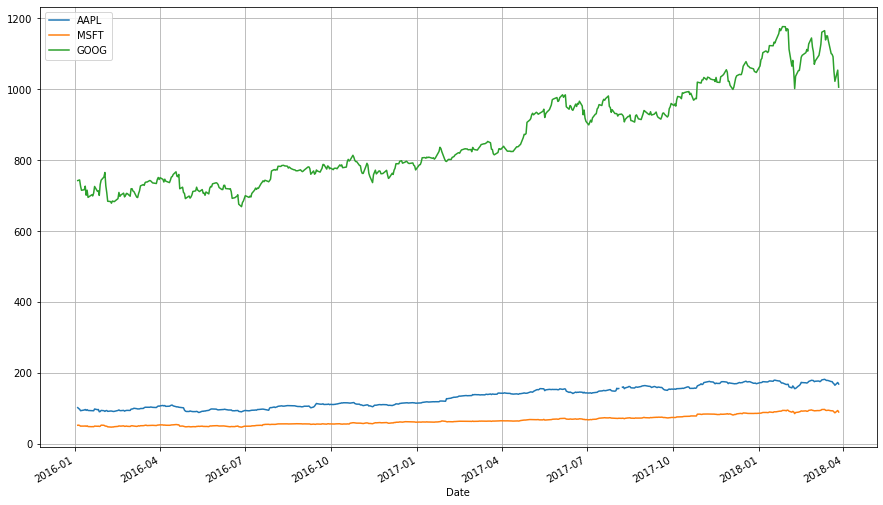

In [9]:
stocks.plot(grid = True)

What’s wrong with this chart? While absolute price is important (pricy stocks are difficult to purchase, which affects not only their volatility but your ability to trade that stock), when trading, we are more concerned about the relative change of an asset rather than its absolute price. Google’s stocks are much more expensive than Apple’s or Microsoft’s, and this difference makes Apple’s and Microsoft’s stocks appear much less volatile than they truly are (that is, their price appears to not deviate much).

One solution would be to use two different scales when plotting the data; one scale will be used by Apple and Microsoft stocks, and the other by Google.

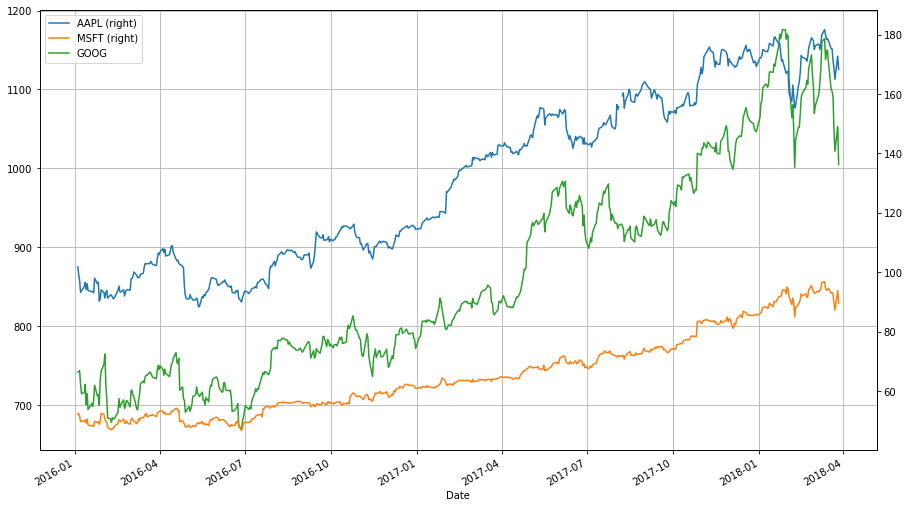

In [10]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

A “better” solution, though, would be to plot the information we actually want: the stock’s returns. This involves transforming the data into something more useful for our purposes. There are multiple transformations we could apply.

One transformation would be to consider the stock’s return since the beginning of the period of interest. In other words, we plot:

\text{return}_{t,0} = \frac{\text{price}_t}{\text{price}_0}

This will require transforming the data in the stocks object, which I do next. Notice that I am using a lambda function, which allows me to pass a small function defined quickly as a parameter to another function or method (you can read more about lambda functions here).

In [11]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head() - 1

AAPL      MSFT      GOOG
Date                                    
2016-01-04  0.000000  0.000000  0.000000
2016-01-05 -0.025059  0.004562  0.000998
2016-01-06 -0.044139 -0.013686  0.002399
2016-01-07 -0.084480 -0.047993 -0.020827
2016-01-08 -0.079639 -0.045073 -0.036895

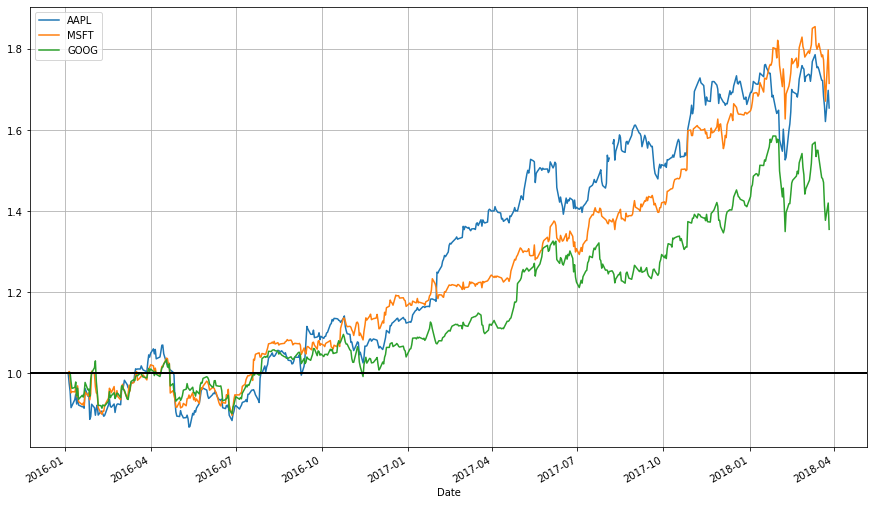

In [12]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

This is a much more useful plot. We can now see how profitable each stock was since the beginning of the period. Furthermore, we see that these stocks are highly correlated; they generally move in the same direction, a fact that was difficult to see in the other charts.

Alternatively, we could plot the change of each stock per day. One way to do so would be to plot the percentage increase of a stock when comparing day t to day t + 1, with the formula:

\text{growth}_t = \frac{\text{price}_{t + 1} - \text{price}_t}{\text{price}_t}

But change could be thought of differently as:

\text{increase}_t = \frac{\text{price}_{t} - \text{price}_{t-1}}{\text{price}_t}

These formulas are not the same and can lead to differing conclusions, but there is another way to model the growth of a stock: with log differences.

\text{change}_t = \log(\text{price}_{t}) - \log(\text{price}_{t - 1})

(Here, \log is the natural log, and our definition does not depend as strongly on whether we use \log(\text{price}_{t}) - \log(\text{price}_{t - 1}) or \log(\text{price}_{t+1}) - \log(\text{price}_{t}).) The advantage of using log differences is that this difference can be interpreted as the percentage change in a stock but does not depend on the denominator of a fraction. Additionally, log differences have a desirable property: the sum of the log differences can be interpreted as the total change (as a percentage) over the period summed (which is not a property of the other formulations; they will overestimate growth). Log differences also more cleanly correspond to how stock prices are modeled in continuous time.

We can obtain and plot the log differences of the data in stocks as follows:

In [13]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

AAPL      MSFT      GOOG
Date                                    
2016-01-04       NaN       NaN       NaN
2016-01-05 -0.025379  0.004552  0.000997
2016-01-06 -0.019764 -0.018332  0.001400
2016-01-07 -0.043121 -0.035402 -0.023443
2016-01-08  0.005274  0.003062 -0.016546

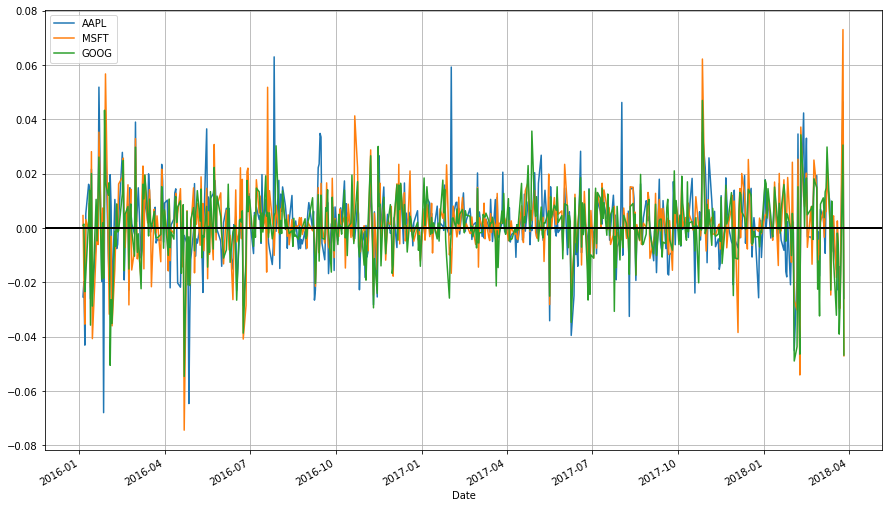

In [14]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

Which transformation do you prefer? Looking at returns since the beginning of the period make the overall trend of the securities in question much more apparent. Changes between days, though, are what more advanced methods actually consider when modelling the behavior of a stock. so they should not be ignored.

We often want to compare the performance of stocks to the performance of the overall market. SPY, which is the ticker symbol for the SPDR S&P 500 exchange-traded mutual fund (ETF), is a fund that attempts only to imitate the composition of the S&P 500 stock index, and thus represents the value in “the market.”

SPY data is not available for free from Quandl, so I will get this data from Yahoo! Finance. (I don’t have a choice.)

Below I get data for SPY and compare its performance to the performance of our stocks.

In [15]:
import pandas_datareader.data as web    # Going to get SPY from Yahoo! (I know I said you shouldn't but I didn't have a choice)
from pandas.util.testing import assert_frame_equal
import pandas as pd

spyder = web.DataReader("SPY", "yahoo", start=start, end=end)    # Didn't work

spyder.to_csv(r'C:\Users\gordo\Programming\Data_Bank\STOCK_DATA_ANALYSIS\HistoricalQuotes13.csv')

spyderdat = pd.read_csv(r'C:\Users\gordo\Programming\Data_Bank\STOCK_DATA_ANALYSIS\HistoricalQuotes13.csv', index_col='Date')    

# Obviously specific to my system; set to
# location on your machine

spyder=pd.DataFrame(spyderdat['Adj Close'])

spyder.rename(columns={'Adj Close': 'SPY'}, inplace=True)

stocks=stocks.join(spyder)

stocks

AAPL       MSFT     GOOG         SPY
Date                                                  
2016-01-04  101.783763  52.181598   741.84  185.922073
2016-01-05   99.233131  52.419653   742.58  186.236526
2016-01-06   97.291172  51.467434   743.62  183.887283
2016-01-07   93.185040  49.677262   726.39  179.475525
2016-01-08   93.677776  49.829617   714.47  177.505524
...                ...        ...      ...         ...
2018-03-21  171.270000  92.480000  1090.88  261.500183
2018-03-22  168.845000  89.790000  1049.08  254.963379
2018-03-23  164.940000  87.180000  1021.57  249.528961
2018-03-26  172.770000  93.780000  1053.21  256.355865
2018-03-27  168.340000  89.470000  1005.10  251.994781

[561 rows x 4 columns]

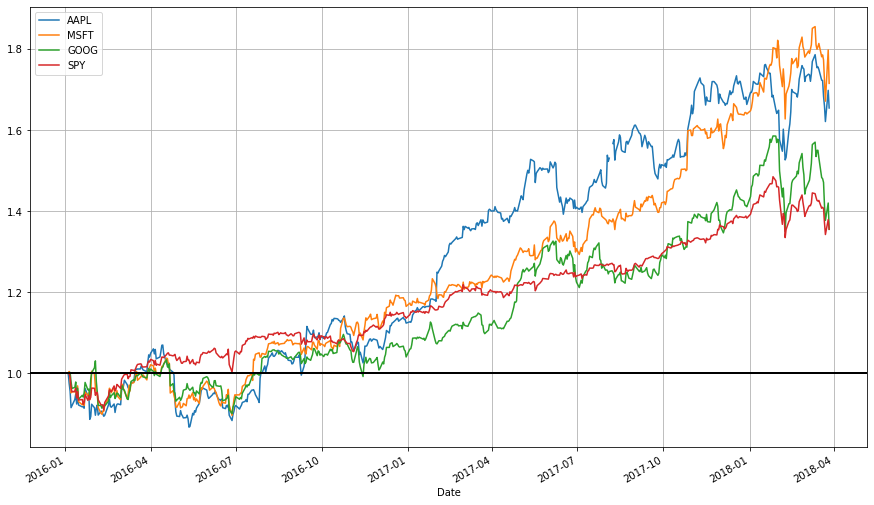

In [16]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

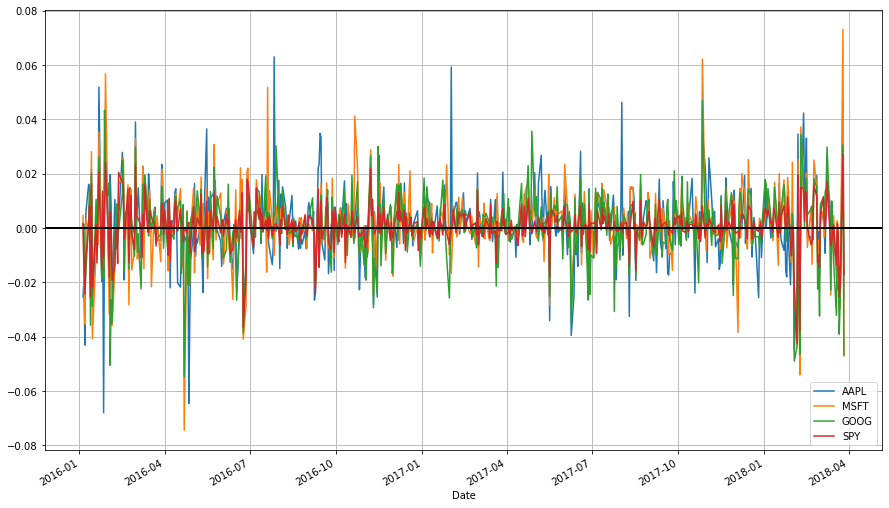

In [17]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
stock_change.plot(grid=True).axhline(y = 0, color = "black", lw = 2)

# Classical Risk Metrics
From what we have so far we can already compute informative metrics for our stocks, which can be considered some measure of risk.

First, we will want to annualize our returns, thus computing the annual percentage rate (APR). This helps us keep returns on a common time scale.

In [18]:
stock_change_apr = stock_change * 252 * 100    # There are 252 trading days in a year; the 100 converts to percentages
stock_change_apr.tail()

AAPL         MSFT         GOOG         SPY
Date                                                         
2018-03-21  -577.463148  -176.499833  -157.285338  -48.410496
2018-03-22  -359.355133  -743.873619  -984.592233 -637.939537
2018-03-23  -589.663945  -743.366326  -669.637836 -542.932422
2018-03-26  1168.762361  1839.012005   768.649993  680.188153
2018-03-27  -654.582257 -1185.615651 -1178.241231 -432.386634

Some of these numbers look initially like nonsense, but that’s okay for now.

The metrics I want are:

The average return
Volatility (the standard deviation of returns)
\alpha and \beta
The Sharpe ratio
The first two metrics are largely self-explanatory, but the latter two need explaining.

First, the risk-free rate, which I denote by r_{RF}, is the rate of return on a risk-free financial asset. This asset exists only in theory but often yields on low-risk instruments like 3-month U.S. Treasury Bills can be viewed as being virtually risk-free and thus their yields can be used to approximate the risk-free rate. I get the data for these instruments below.

In [19]:
tbill = quandl.get("FRED/TB3MS", start_date=start, end_date=end)
tbill.tail()

Value
Date             
2019-09-01   1.89
2019-10-01   1.65
2019-11-01   1.54
2019-12-01   1.54
2020-01-01   1.52

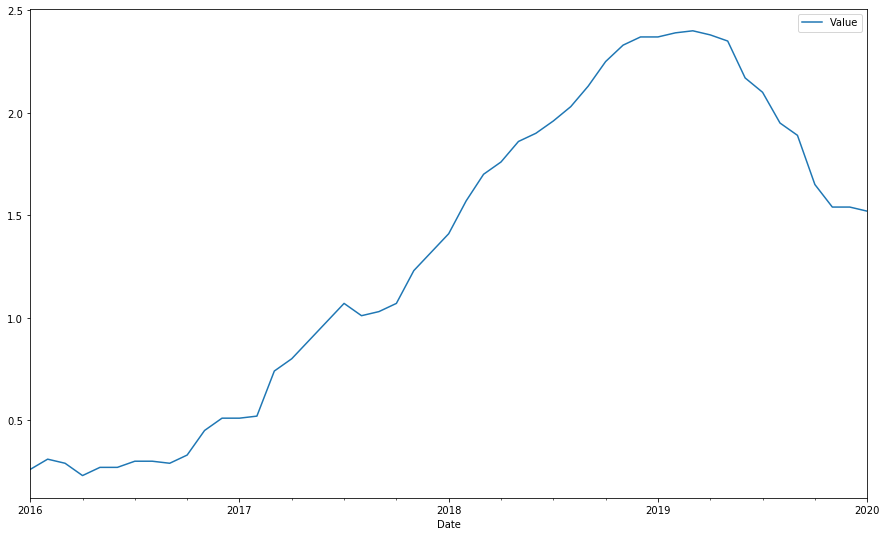

In [20]:
tbill.plot()

In [21]:
rrf = tbill.iloc[-1, 0]    # Get the most recent Treasury Bill rate
rrf

1.52

Now, a linear regression model is a model of the following form:

y_i = \alpha + \beta x_i + \epsilon_i

\epsilon_i is an error process. Another way to think of this process model is:

\hat{y}_i = \alpha + \beta x_i

\hat{y}_i is the predicted value of y_i given x_i. In other words, a linear regression model tells you how x_i and y_i are related, and how values of x_i can be used to predict values of y_i. \alpha is the intercept of the model and \beta is the slope. In particular, \alpha would be the predicted value of y if x were zero, and \beta gives how much y changes when x changes by one unit.

There is an easy way to compute \alpha and \beta given the sample means \bar{x} and \bar{y} and sample standard deviations s_x and s_y and the correlation between x and $y$, denoted with r:

\beta = r \frac{s_y}{s_x}
\alpha = \bar{y} - \beta \bar{x}

In finance, we use \alpha and \beta like so:

R_t - r_{RF} = \alpha + \beta (R_{Mt} - r_{RF}) + \epsilon_t

R_t is the return of a financial asset (a stock) and R_t - r_{RF} is the excess return, or return exceeding the risk-free rate of return. R_{Mt} is the return of the market at time t. Then \alpha and \beta can be interpreted like so:

\alpha is average excess return over the market.
\beta is how much a stock moves in relation to the market. If \beta > 0 then the stock generally moves in the same direction as the market, while when \beta  1 the stock moves strongly in response to the market |\beta| < 1 the stock is less responsive to the market.
Below I get a pandas Series that contains how much each stock is correlated with SPY (our approximation of the market).

In [22]:
smcorr = stock_change_apr.drop('SPY', 1).corrwith(stock_change_apr.SPY)    # Since RRF is constant it doesn't change the
                                                                           # correlation so we can ignore it in our
                                                                           # calculation
smcorr

AAPL    0.592219
MSFT    0.722940
GOOG    0.672283
dtype: float64

In [23]:
sy = stock_change_apr.drop("SPY", 1).std()
sx = stock_change_apr.SPY.std()
sy

AAPL    339.921782
MSFT    329.308164
GOOG    312.319468
dtype: float64

In [24]:
sx    # Standard deviation for x

187.3079536126796

In [25]:
ybar = stock_change_apr.drop("SPY", 1).mean() - rrf
xbar = stock_change_apr.SPY.mean() - rrf
ybar

AAPL    20.149035
MSFT    22.742806
GOOG    12.146893
dtype: float64

In [26]:
xbar

12.1636339040289

In [27]:
beta = smcorr * sy / sx
alpha = ybar - beta * xbar
beta

AAPL    1.074745
MSFT    1.271009
GOOG    1.120973
dtype: float64

In [28]:
alpha

AAPL    7.076233
MSFT    7.282718
GOOG   -1.488207
dtype: float64

The Sharpe ratio is another popular risk metric, defined below:

\text{Sharpe ratio} = \frac{\bar{R_t} - r_{RF}}{s}

Here s is the volatility of the stock. We want the sharpe ratio to be large. A large Sharpe ratio indicates that the stock's excess returns are large relative to the stock's volatilitly. Additionally, the Sharpe ratio is tied to a statistical test (the t-test) to determine if a stock earns more on average than the risk-free rate; the larger this ratio, the more likely this is to be the case.

Your challenge now is to compute the Sharpe ratio for each stock listed here, and interpret it. Which stock seems to be the better investment according to the Sharpe ratio?

In [29]:
sharpe = (ybar - rrf)/sy
sharpe

AAPL    0.054804
MSFT    0.064447
GOOG    0.034026
dtype: float64

In [30]:
(xbar - rrf)/sx

0.056824249577986916

# Moving Averages
Charts are very useful. In fact, some traders base their strategies almost entirely off charts (these are the "technicians", since trading strategies based off finding patterns in charts is a part of the trading doctrine known as technical analysis). Let's now consider how we can find trends in stocks.

A q-day moving average is, for a series x_t and a point in time t, the average of the past q days: that is, if MA^q_t denotes a moving average process, then:

MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}

Moving averages smooth a series and helps identify trends. The larger q is, the less responsive a moving average process is to short-term fluctuations in the series x_t. The idea is that moving average processes help identify trends from "noise". Fast moving averages have smaller q and more closely follow the stock, while slow moving averages have larger q, resulting in them responding less to the fluctuations of the stock and being more stable.

pandas provides functionality for easily computing moving averages. I demonstrate its use by creating a 20-day (one month) moving average for the Apple data, and plotting it alongside the stock.

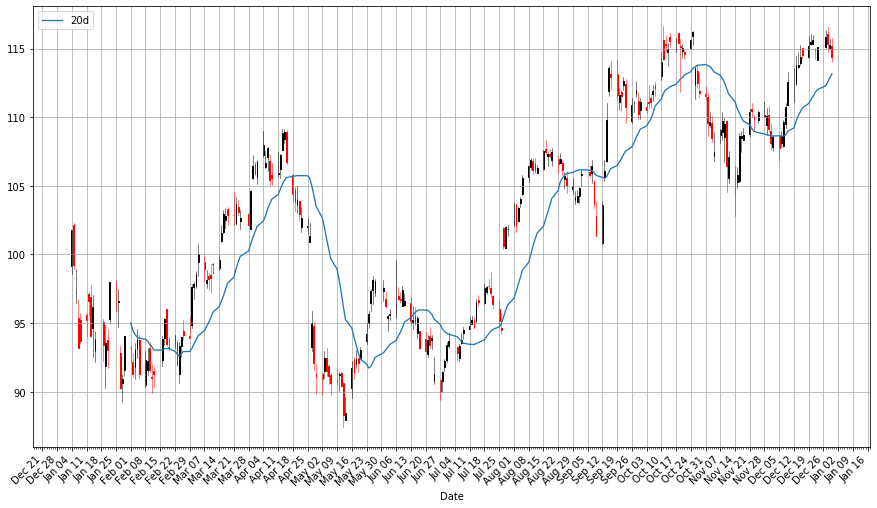

In [31]:
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = "20d", adj=True)

Notice how late the rolling average begins. It cannot be computed until 20 days have passed. This limitation becomes more severe for longer moving averages. Because I would like to be able to compute 200-day moving averages, I'm going to extend out how much AAPL data we have. That said, we will still largely focus on 2016.

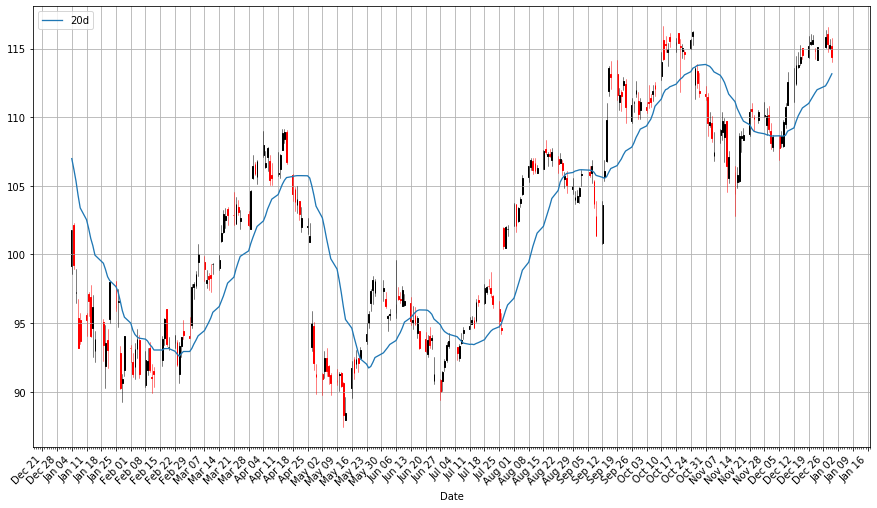

In [32]:
start = datetime.datetime(2010,1,1)
apple = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = "20d", adj=True)

You will notice that a moving average is much smoother than the actua stock data. Additionally, it’s a stubborn indicator; a stock needs to be above or below the moving average line in order for the line to change direction. Thus, crossing a moving average signals a possible change in trend, and should draw attention.

Traders are usually interested in multiple moving averages, such as the 20-day, 50-day, and 200-day moving averages. It’s easy to examine multiple moving averages at once.

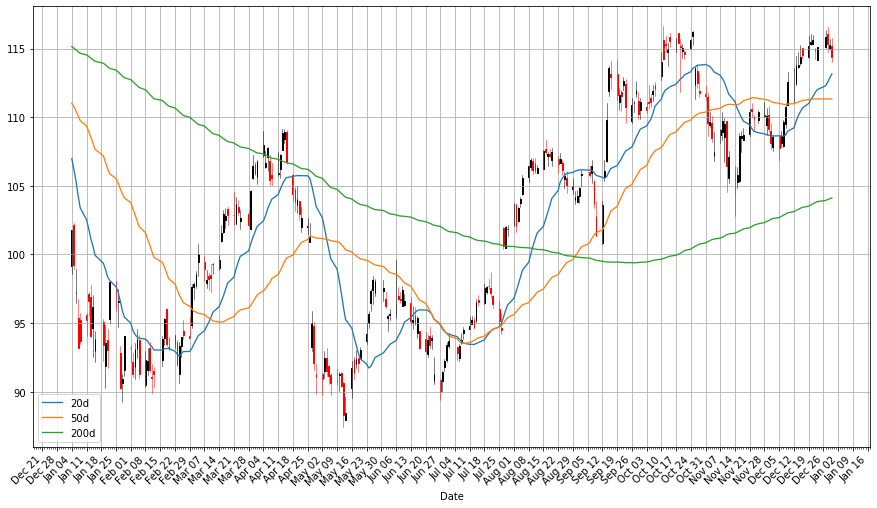

In [33]:
apple["50d"] = np.round(apple["Adj. Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Adj. Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = ["20d", "50d", "200d"], adj=True)

The 20-day moving average is the most sensitive to local changes, and the 200-day moving average the least. Here, the 200-day moving average indicates an overall bearish trend: the stock is trending downward over time. The 20-day moving average is at times bearish and at other times bullish, where a positive swing is expected. You can also see that the crossing of moving average lines indicate changes in trend. These crossings are what we can use as trading signals, or indications that a financial security is changind direction and a profitable trade might be made.

# Trading Strategy
Our concern now is to design and evaluate trading strategies.

Any trader must have a set of rules that determine how much of her money she is willing to bet on any single trade. For example, a trader may decide that under no circumstances will she risk more than 10% of her portfolio on a trade. Additionally, in any trade, a trader must have an exit strategy, a set of conditions determining when she will exit the position, for either profit or loss. A trader may set a target, which is the minimum profit that will induce the trader to leave the position. Likewise, a trader may have a maximum loss she is willing to tolerate; if potential losses go beyond this amount, the trader will exit the position in order to prevent any further loss. We will suppose that the amount of money in the portfolio involved in any particular trade is a fixed proportion; 10% seems like a good number.

Here, I will be demonstrating a moving average crossover strategy. We will use two moving averages, one we consider “fast”, and the other “slow”. The strategy is:

Trade the asset when the fast moving average crosses over the slow moving average.
Exit the trade when the fast moving average crosses over the slow moving average again.
A trade will be prompted when the fast moving average crosses from below to above the slow moving average, and the trade will be exited when the fast moving average crosses below the slow moving average later.

We now have a complete strategy. But before we decide we want to use it, we should try to evaluate the quality of the strategy first. The usual means for doing so is backtesting, which is looking at how profitable the strategy is on historical data. For example, looking at the above chart’s performance on Apple stock, if the 20-day moving average is the fast moving average and the 50-day moving average the slow, this strategy does not appear to be very profitable, at least not if you are always taking long positions.

Let’s see if we can automate the backtesting task. We first identify when the 20-day average is below the 50-day average, and vice versa.

In [34]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2018-03-21  175.04  175.09  171.26  171.270  35247358.0          0.0   
2018-03-22  170.00  172.68  168.60  168.845  41051076.0          0.0   
2018-03-23  168.39  169.92  164.94  164.940  40248954.0          0.0   
2018-03-26  168.07  173.10  166.44  172.770  36272617.0          0.0   
2018-03-27  173.68  175.15  166.92  168.340  38962839.0          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj. Low  Adj. Close  \
Date                                                                  
2018-03-21          1.0     175.04     175.09    171.26     171.270   
2018-03-22          1.0     170.00     172.68    168.60     168.845   
2018-03-23          1.0     168.39     169.92    164.94     164.940   
2018-03-26          1.0     168.07     173.10    166.44     172.770   
2018-03-27          1.0     173.68     175.15    166.92     168.340   

            Adj. Volume     20d     50d    200d  20d-50d  
Date                                                      
2018-03-21   35247358.0  176.94  172.57  162.68     4.37  
2018-03-22   41051076.0  176.76  172.46  162.75     4.30  
2018-03-23   40248954.0  176.23  172.27  162.81     3.96  
2018-03-26   36272617.0  175.92  172.22  162.91     3.70  
2018-03-27   38962839.0  175.41  172.05  162.98     3.36

We will refer to the sign of this difference as the regime; that is, if the fast moving average is above the slow moving average, this is a bullish regime (the bulls rule), and a bearish regime (the bears rule) holds when the fast moving average is below the slow moving average. I identify regimes with the following code.

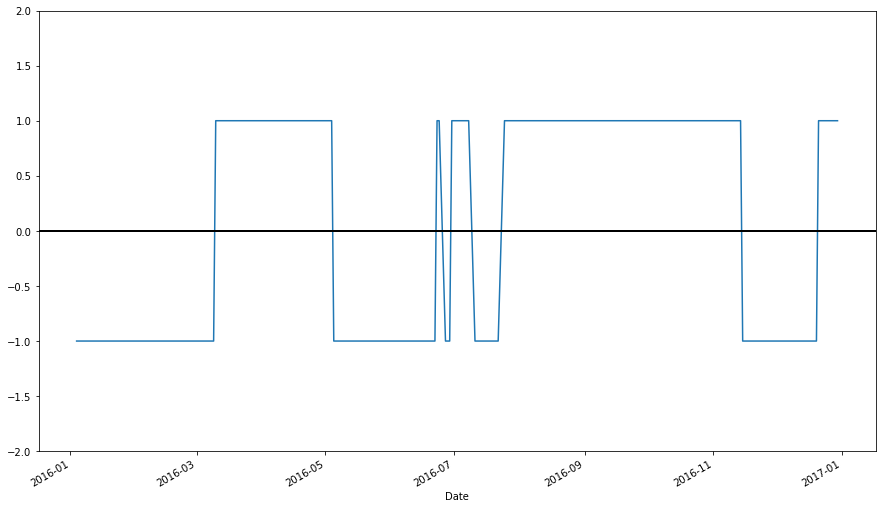

In [35]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-04':'2016-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)


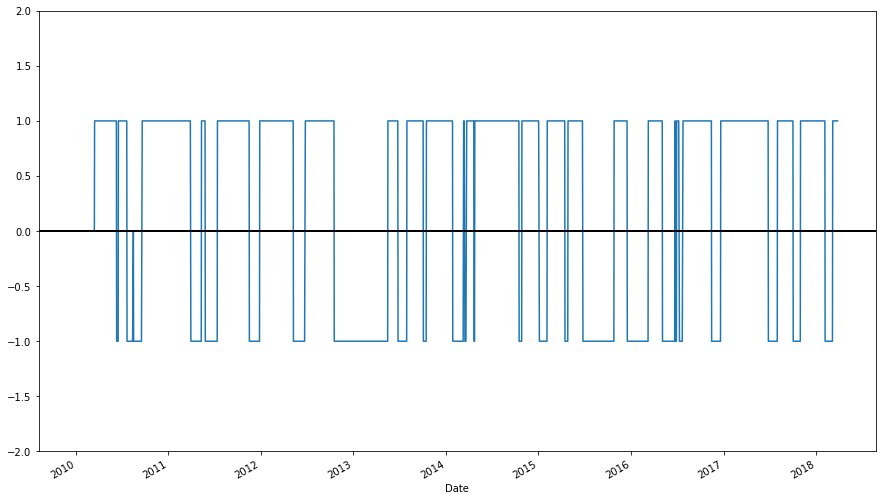

In [36]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [37]:
apple["Regime"].value_counts()

 1    1323
-1     694
 0      53
Name: Regime, dtype: int64

The last line above indicates that for 1005 days the market was bearish on Apple, while for 600 days the market was bullish, and it was neutral for 54 days.

Trading signals appear at regime changes. When a bullish regime begins, a buy signal is triggered, and when it ends, a sell signal is triggered. Likewise, when a bearish regime begins, a sell signal is triggered, and when the regime ends, a buy signal is triggered (this is of interest only if you ever will short the stock, or use some derivative like a stock option to bet against the market).

It's simple to obtain signals. Let r_t indicate the regime at time t, and s_t the signal at time t. Then:

s_t = \text{sign}(r_t - r_{t - 1})

s_t \in \{-1, 0, 1\}, with -1 indicating "sell", 1 indicating "buy", and 0 no action. We can obtain signals like so:

In [40]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.loc[:, "Regime"].iloc[-1]
apple.loc[:, "Regime"].iloc[-1] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.loc[:, "Regime"].iloc[-1] = regime_orig
apple.tail()

C:\Users\gordo\AppData\Local\Continuum\anaconda3\envs\notebook\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\gordo\AppData\Local\Continuum\anaconda3\envs\notebook\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2018-03-21  175.04  175.09  171.26  171.270  35247358.0          0.0   
2018-03-22  170.00  172.68  168.60  168.845  41051076.0          0.0   
2018-03-23  168.39  169.92  164.94  164.940  40248954.0          0.0   
2018-03-26  168.07  173.10  166.44  172.770  36272617.0          0.0   
2018-03-27  173.68  175.15  166.92  168.340  38962839.0          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj. Low  Adj. Close  \
Date                                                                  
2018-03-21          1.0     175.04     175.09    171.26     171.270   
2018-03-22          1.0     170.00     172.68    168.60     168.845   
2018-03-23          1.0     168.39     169.92    164.94     164.940   
2018-03-26          1.0     168.07     173.10    166.44     172.770   
2018-03-27          1.0     173.68     175.15    166.92     168.340   

            Adj. Volume     20d     50d    200d  20d-50d  Regime  Signal  
Date                                                                      
2018-03-21   35247358.0  176.94  172.57  162.68     4.37       1     0.0  
2018-03-22   41051076.0  176.76  172.46  162.75     4.30       1     0.0  
2018-03-23   40248954.0  176.23  172.27  162.81     3.96       1     0.0  
2018-03-26   36272617.0  175.92  172.22  162.91     3.70       1     0.0  
2018-03-27   38962839.0  175.41  172.05  162.98     3.36       1    -1.0

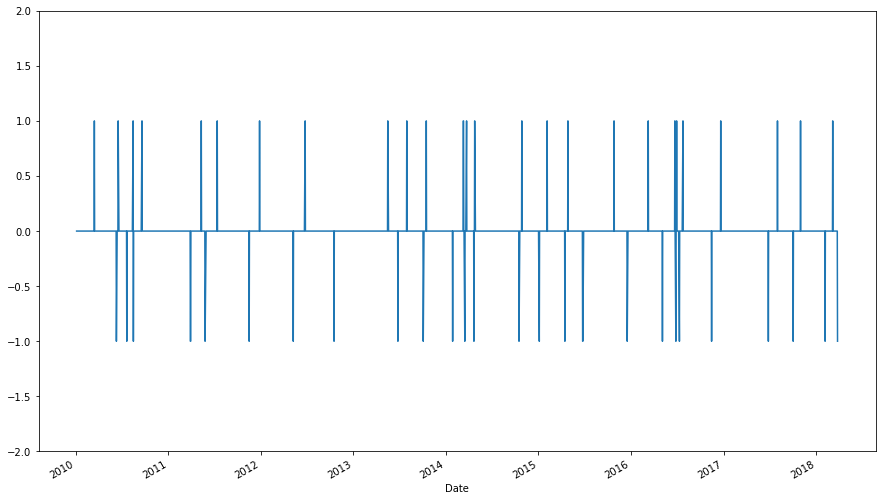

In [41]:
apple["Signal"].plot(ylim = (-2, 2))

In [42]:
apple["Signal"].value_counts()

 0.0    2014
-1.0      28
 1.0      27
Name: Signal, dtype: int64

We would buy Apple stock 23 times and sell Apple stock 23 times. If we only go long on Apple stock, only 23 trades will be engaged in over the 6-year period, while if we pivot from a long to a short position every time a long position is terminated, we would engage in 23 trades total. (Bear in mind that trading more frequently isn’t necessarily good; trades are never free.)

You may notice that the system as it currently stands isn’t very robust, since even a fleeting moment when the fast moving average is above the slow moving average triggers a trade, resulting in trades that end immediately (which is bad if not simply because realistically every trade is accompanied by a fee that can quickly erode earnings). Additionally, every bullish regime immediately transitions into a bearish regime, and if you were constructing trading systems that allow both bullish and bearish bets, this would lead to the end of one trade immediately triggering a new trade that bets on the market in the opposite direction, which again seems finnicky. A better system would require more evidence that the market is moving in some particular direction. But we will not concern ourselves with these details for now.

Let’s now try to identify what the prices of the stock is at every buy and every sell.

In [43]:
apple.loc[apple["Signal"] == 1, "Close"]

Date
2010-03-16    224.450
2010-06-18    274.074
2010-08-16    247.640
2010-09-20    283.230
2011-05-12    346.570
2011-07-14    357.770
2011-12-28    402.640
2012-06-25    570.765
2013-05-17    433.260
2013-07-31    452.530
2013-10-16    501.114
2014-03-11    536.090
2014-03-12    536.610
2014-03-24    539.190
2014-04-25    571.940
2014-10-28    106.740
2015-02-05    119.940
2015-04-28    130.560
2015-10-27    114.550
2016-03-10    101.170
2016-06-23     96.100
2016-06-30     95.600
2016-07-25     97.340
2016-12-21    117.060
2017-08-02    157.140
2017-11-01    166.890
2018-03-08    176.940
Name: Close, dtype: float64

In [44]:
apple.loc[apple["Signal"] == -1, "Close"]

Date
2010-06-11    253.5100
2010-07-22    259.0240
2010-08-17    251.9700
2011-03-30    348.6300
2011-03-31    348.5075
2011-05-27    337.4100
2011-11-17    377.4100
2012-05-09    569.1800
2012-10-17    644.6136
2013-06-26    398.0700
2013-10-04    483.0300
2014-01-28    506.5000
2014-03-17    526.7400
2014-04-22    531.6990
2014-10-17     97.6700
2015-01-05    106.2500
2015-04-16    126.1700
2015-06-25    127.5000
2015-06-26    126.7500
2015-12-18    106.0300
2016-05-05     93.2400
2016-06-27     92.0400
2016-07-11     96.9800
2016-11-15    107.1100
2017-06-27    143.7400
2017-10-03    154.4800
2018-02-06    163.0300
2018-03-27    168.3400
Name: Close, dtype: float64

In [45]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

Price  Regime Signal
Date                                 
2010-03-16   28.844953       1    Buy
2010-06-11   32.579568      -1   Sell
2010-06-18   35.222329       1    Buy
2010-07-22   33.288194      -1   Sell
2010-08-16   31.825192       0    Buy
2010-08-17   32.381657      -1   Sell
2010-09-20   36.399003       1    Buy
2011-03-30   44.803814       0   Sell
2011-03-31   44.788071      -1   Sell
2011-05-12   44.539075       1    Buy
2011-05-27   43.361888      -1   Sell
2011-07-14   45.978431       1    Buy
2011-11-17   48.502445      -1   Sell
2011-12-28   51.744852       1    Buy
2012-05-09   73.147563      -1   Sell
2012-06-25   73.351258       1    Buy
2012-10-17   83.195498      -1   Sell
2013-05-17   56.878472       1    Buy
2013-06-26   52.258721      -1   Sell
2013-07-31   59.408242       1    Buy
2013-10-04   63.831819      -1   Sell
2013-10-16   66.221597       1    Buy
2014-01-28   67.325247      -1   Sell
2014-03-11   71.682490       0    Buy
2014-03-12   71.752021       1    Buy
2014-03-17   70.432269      -1   Sell
2014-03-24   72.097002       1    Buy
2014-04-22   71.095354      -1   Sell
2014-04-25   76.476120       1    Buy
2014-10-17   92.387441      -1   Sell
2014-10-28  100.966883       1    Buy
2015-01-05  100.937944      -1   Sell
2015-02-05  114.390004       1    Buy
2015-04-16  120.331722      -1   Sell
2015-04-28  124.518583       1    Buy
2015-06-25  122.104986       0   Sell
2015-06-26  121.386721      -1   Sell
2015-10-27  110.198438       1    Buy
2015-12-18  102.440744      -1   Sell
2016-03-10   98.271427       1    Buy
2016-05-05   91.122295      -1   Sell
2016-06-23   93.917337       1    Buy
2016-06-27   89.949550      -1   Sell
2016-06-30   93.428693       1    Buy
2016-07-11   94.777350      -1   Sell
2016-07-25   95.129174       1    Buy
2016-11-15  105.787035      -1   Sell
2016-12-21  115.614138       1    Buy
2017-06-27  143.159139      -1   Sell
2017-08-02  156.504989       1    Buy
2017-10-03  154.480000      -1   Sell
2017-11-01  166.890000       1    Buy
2018-02-06  163.030000      -1   Sell
2018-03-08  176.940000       1    Buy
2018-03-27  168.340000       1   Sell

In [46]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

Price     Profit   End Date
Date                                        
2010-03-16   28.844953   3.734615 2010-06-11
2010-06-18   35.222329  -1.934135 2010-07-22
2010-09-20   36.399003   8.404812 2011-03-30
2011-05-12   44.539075  -1.177188 2011-05-27
2011-07-14   45.978431   2.524014 2011-11-17
2011-12-28   51.744852  21.402711 2012-05-09
2012-06-25   73.351258   9.844240 2012-10-17
2013-05-17   56.878472  -4.619751 2013-06-26
2013-07-31   59.408242   4.423577 2013-10-04
2013-10-16   66.221597   1.103650 2014-01-28
2014-03-12   71.752021  -1.319753 2014-03-17
2014-03-24   72.097002  -1.001648 2014-04-22
2014-04-25   76.476120  15.911321 2014-10-17
2014-10-28  100.966883  -0.028939 2015-01-05
2015-02-05  114.390004   5.941719 2015-04-16
2015-04-28  124.518583  -2.413598 2015-06-25
2015-10-27  110.198438  -7.757693 2015-12-18
2016-03-10   98.271427  -7.149132 2016-05-05
2016-06-23   93.917337  -3.967788 2016-06-27
2016-06-30   93.428693   1.348657 2016-07-11
2016-07-25   95.129174  10.657861 2016-11-15
2016-12-21  115.614138  27.545001 2017-06-27
2017-08-02  156.504989  -2.024989 2017-10-03
2017-11-01  166.890000  -3.860000 2018-02-06
2018-03-08  176.940000  -8.600000 2018-03-27

Let’s now create a simulated portfolio of $1,000,000, and see how it would behave, according to the rules we have established. This includes:

Investing only 10% of the portfolio in any trade
Exiting the position if losses exceed 20% of the value of the trade.
When simulating, bear in mind that:

Trades are done in batches of 100 stocks.
Our stop-loss rule involves placing an order to sell the stock the moment the price drops below the specified level. Thus we need to check whether the lows during this period ever go low enough to trigger the stop-loss. Realistically, unless we buy a put option, we cannot guarantee that we will sell the stock at the price we set at the stop-loss, but we will use this as the selling price anyway for the sake of simplicity.
Every trade is accompanied by a commission to the broker, which should be accounted for. I do not do so here.
Here’s how a backtest may look:

In [47]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_long_profits.index,
                            "End": apple_long_profits["End Date"]})
apple_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
apple_long_profits

Price     Profit   End Date         Low
Date                                                    
2010-03-16   28.844953   3.734615 2010-06-11   25.606402
2010-06-18   35.222329  -1.934135 2010-07-22   30.791939
2010-09-20   36.399003   8.404812 2011-03-30   35.341333
2011-05-12   44.539075  -1.177188 2011-05-27   42.335061
2011-07-14   45.978431   2.524014 2011-11-17   45.367990
2011-12-28   51.744852  21.402711 2012-05-09   51.471117
2012-06-25   73.351258   9.844240 2012-10-17   72.688768
2013-05-17   56.878472  -4.619751 2013-06-26   51.942335
2013-07-31   59.408242   4.423577 2013-10-04   59.001273
2013-10-16   66.221597   1.103650 2014-01-28   65.972629
2014-03-12   71.752021  -1.319753 2014-03-17   69.932180
2014-03-24   72.097002  -1.001648 2014-04-22   68.371743
2014-04-25   76.476120  15.911321 2014-10-17   75.409086
2014-10-28  100.966883  -0.028939 2015-01-05   99.652062
2015-02-05  114.390004   5.941719 2015-04-16  112.949876
2015-04-28  124.518583  -2.413598 2015-06-25  117.651750
2015-10-27  110.198438  -7.757693 2015-12-18  102.228192
2016-03-10   98.271427  -7.149132 2016-05-05   89.752692
2016-06-23   93.917337  -3.967788 2016-06-27   89.421814
2016-06-30   93.428693   1.348657 2016-07-11   92.158220
2016-07-25   95.129174  10.657861 2016-11-15   94.230069
2016-12-21  115.614138  27.545001 2017-06-27  113.342546
2017-08-02  156.504989  -2.024989 2017-10-03  149.160000
2017-11-01  166.890000  -3.860000 2018-02-06  154.000000
2018-03-08  176.940000  -8.600000 2018-03-27  164.940000

In [48]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
    
apple_backtest

Start Port. Value  End Port. Value   End Date  Shares  \
2010-03-16       1.000000e+06     1.012698e+06 2010-06-11  3400.0   
2010-06-18       1.012698e+06     1.007282e+06 2010-07-22  2800.0   
2010-09-20       1.007282e+06     1.029975e+06 2011-03-30  2700.0   
2011-05-12       1.029975e+06     1.027268e+06 2011-05-27  2300.0   
2011-07-14       1.027268e+06     1.032820e+06 2011-11-17  2200.0   
2011-12-28       1.032820e+06     1.073486e+06 2012-05-09  1900.0   
2012-06-25       1.073486e+06     1.087267e+06 2012-10-17  1400.0   
2013-05-17       1.087267e+06     1.078490e+06 2013-06-26  1900.0   
2013-07-31       1.078490e+06     1.086452e+06 2013-10-04  1800.0   
2013-10-16       1.086452e+06     1.088218e+06 2014-01-28  1600.0   
2014-03-12       1.088218e+06     1.086239e+06 2014-03-17  1500.0   
2014-03-24       1.086239e+06     1.084736e+06 2014-04-22  1500.0   
2014-04-25       1.084736e+06     1.107012e+06 2014-10-17  1400.0   
2014-10-28       1.107012e+06     1.106983e+06 2015-01-05  1000.0   
2015-02-05       1.106983e+06     1.112331e+06 2015-04-16   900.0   
2015-04-28       1.112331e+06     1.110400e+06 2015-06-25   800.0   
2015-10-27       1.110400e+06     1.102642e+06 2015-12-18  1000.0   
2016-03-10       1.102642e+06     1.094778e+06 2016-05-05  1100.0   
2016-06-23       1.094778e+06     1.090413e+06 2016-06-27  1100.0   
2016-06-30       1.090413e+06     1.091897e+06 2016-07-11  1100.0   
2016-07-25       1.091897e+06     1.103621e+06 2016-11-15  1100.0   
2016-12-21       1.103621e+06     1.128411e+06 2017-06-27   900.0   
2017-08-02       1.128411e+06     1.126994e+06 2017-10-03   700.0   
2017-11-01       1.126994e+06     1.124678e+06 2018-02-06   600.0   
2018-03-08       1.124678e+06     1.119518e+06 2018-03-27   600.0   

            Share Price    Trade Value  Profit per Share  Total Profit  \
2010-03-16    28.844953   98072.841239          3.734615  12697.691096   
2010-06-18    35.222329   98622.521053         -1.934135  -5415.577333   
2010-09-20    36.399003   98277.306914          8.404812  22692.991110   
2011-05-12    44.539075  102439.873355         -1.177188  -2707.531638   
2011-07-14    45.978431  101152.549241          2.524014   5552.830218   
2011-12-28    51.744852   98315.218526         21.402711  40665.151235   
2012-06-25    73.351258  102691.760672          9.844240  13781.935982   
2013-05-17    56.878472  108069.096937         -4.619751  -8777.527400   
2013-07-31    59.408242  106934.835757          4.423577   7962.438409   
2013-10-16    66.221597  105954.555657          1.103650   1765.839598   
2014-03-12    71.752021  107628.031714         -1.319753  -1979.628917   
2014-03-24    72.097002  108145.503103         -1.001648  -1502.472160   
2014-04-25    76.476120  107066.568572         15.911321  22275.849051   
2014-10-28   100.966883  100966.883069         -0.028939    -28.938709   
2015-02-05   114.390004  102951.003221          5.941719   5347.546691   
2015-04-28   124.518583   99614.866549         -2.413598  -1930.878038   
2015-10-27   110.198438  110198.437846         -7.757693  -7757.693367   
2016-03-10    98.271427  108098.569555         -7.149132  -7864.045388   
2016-06-23    93.917337  103309.070918         -3.967788  -4364.566368   
2016-06-30    93.428693  102771.562745          1.348657   1483.522558   
2016-07-25    95.129174  104642.091188         10.657861  11723.647322   
2016-12-21   115.614138  104052.724175         27.545001  24790.501098   
2017-08-02   156.504989  109553.492367         -2.024989  -1417.492367   
2017-11-01   166.890000  100134.000000         -3.860000  -2316.000000   
2018-03-08   176.940000  106164.000000         -8.600000  -5160.000000   

            Stop-Loss Triggered  
2010-03-16                  0.0  
2010-06-18                  0.0  
2010-09-20                  0.0  
2011-05-12                  0.0  
2011-07-14                  0.0  
2011-12-28                  0.0  
2012-06-25                  0.0  
2013-05-17          

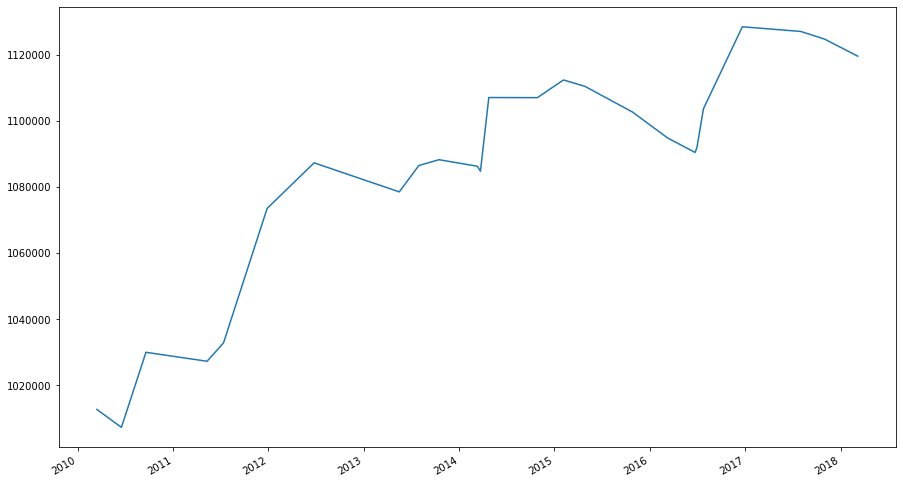

In [49]:
apple_backtest["End Port. Value"].plot()

Our portfolio’s value grew by 13% in about six years. Considering that only 10% of the portfolio was ever involved in any single trade, this is not bad performance.

Notice that this strategy never lead to our rule of never allowing losses to exceed 20% of the trade’s value being invoked. For the sake of simplicity, we will ignore this rule in backtesting.

A more realistic portfolio would not be betting 10% of its value on only one stock. A more realistic one would consider investing in multiple stocks. Multiple trades may be ongoing at any given time involving multiple companies, and most of the portfolio will be in stocks, not cash. Now that we will be investing in multiple stops and exiting only when moving averages cross (not because of a stop-loss), we will need to change our approach to backtesting. For example, we will be using one pandas DataFrame to contain all buy and sell orders for all stocks being considered, and our loop above will have to track more information.

I have written functions for creating order data for multiple stocks, and a function for performing the backtesting.

In [50]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing
    :the ticker symbol of each stock (or however you want the stock represented, so long as it's unique),
    :and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date 
    :like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a 
    :moving average crossover strategy, returning a data frame with information about when the stocks in the 
    :portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component 
        # of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish 
        # regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].loc[:, "Regime"].iloc[-1]
        s[1].loc[:, "Regime"].iloc[-1] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        
        # Restore original regime data
        s[1].loc[:, "Regime"].iloc[-1] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 

def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, 
    :like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in 
    :the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   
        
        # Shares could potentially be a positive or negative number         
        # (cash_change will be added in the end; negative shares indicate a short)
        # For a given symbol, a position is effectively cleared
        
        portfolio[index[SYMBOL]] = 0  
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  
        # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) 
            
            # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] 
            
            # How much money is put on the line with each trade
            cash_change -= trade_val  
            # We are buying shares so cash will go down
            
            portfolio[index[SYMBOL]] = batches * batch  
            # Recording how many shares are currently invested in the stock
            
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   
    # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results
 
# Get more stocks
(microsoft, google, facebook, twitter, netflix,
amazon, yahoo, ge, qualcomm, ibm, hp) = (quandl.get("WIKI/" + s,
                                                    start_date=start,
                                                    end_date=end) for s in ["MSFT", "GOOG", "FB", "TWTR",
                                                                            "NFLX", "AMZN", "YHOO", "GE",
                                                                            "QCOM", "IBM", "HPQ"])

In [51]:
signals = ma_crossover_orders([("AAPL", apple),
                              ("MSFT",  microsoft),
                              ("GOOG",  google),
                              ("FB",    facebook),
                              ("TWTR",  twitter),
                              ("NFLX",  netflix),
                              ("AMZN",  amazon),
                              ("YHOO",  yahoo),
                              ("GE",    ge),
                              ("QCOM",  qualcomm),
                              ("IBM",   ibm),
                              ("HPQ",   hp)],
                            fast = 20, slow = 50)
signals

C:\Users\gordo\AppData\Local\Continuum\anaconda3\envs\notebook\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\gordo\AppData\Local\Continuum\anaconda3\envs\notebook\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


Price  Regime Signal
Date       Symbol                           
2010-03-16 AAPL     28.844953     1.0    Buy
           AMZN    131.790000     1.0    Buy
           GE       14.129260     1.0    Buy
           HPQ      19.921951     1.0    Buy
           IBM     105.460506     1.0    Buy
...                       ...     ...    ...
2018-03-27 IBM     151.910000    -1.0    Buy
           MSFT     89.470000     1.0   Sell
           NFLX    300.690000     1.0   Sell
           QCOM     54.840000    -1.0    Buy
           TWTR     28.070000     1.0   Sell

[509 rows x 3 columns]

In [63]:
signals=pd.DataFrame(signals)
signals

Price  Regime Signal
Date       Symbol                           
2010-03-16 AAPL     28.844953     1.0    Buy
           AMZN    131.790000     1.0    Buy
           GE       14.129260     1.0    Buy
           HPQ      19.921951     1.0    Buy
           IBM     105.460506     1.0    Buy
...                       ...     ...    ...
2018-03-27 IBM     151.910000    -1.0    Buy
           MSFT     89.470000     1.0   Sell
           NFLX    300.690000     1.0   Sell
           QCOM     54.840000    -1.0    Buy
           TWTR     28.070000     1.0   Sell

[509 rows x 3 columns]

In [52]:
bk = backtest(signals, 1000000)
bk

Start Cash      End Cash  Portfolio Value  Type  Shares  \
Date       Symbol                                                              
2010-03-16 AAPL    1.000000e+06  9.019272e+05     1.000000e+06   Buy  3400.0   
           AMZN    9.019272e+05  8.096742e+05     1.000000e+06   Buy   700.0   
           GE      8.096742e+05  7.107693e+05     1.000000e+06   Buy  7000.0   
           HPQ     7.107693e+05  6.111596e+05     1.000000e+06   Buy  5000.0   
           IBM     6.111596e+05  5.162451e+05     1.000000e+06   Buy   900.0   
...                         ...           ...              ...   ...     ...   
2018-03-27 IBM     1.740412e+06  1.740412e+06     2.350900e+06   Buy     0.0   
           MSFT    1.740412e+06  2.026716e+06     2.451672e+06  Sell     0.0   
           NFLX    2.026716e+06  2.327406e+06     2.543052e+06  Sell     0.0   
           QCOM    2.327406e+06  2.327406e+06     2.543052e+06   Buy     0.0   
           TWTR    2.327406e+06  2.683895e+06     2.683895e+06  Sell     0.0   

                   Share Price    Trade Value  Profit per Share  Total Profit  
Date       Symbol                                                              
2010-03-16 AAPL      28.844953   98072.841239          0.000000           0.0  
           AMZN     131.790000   92253.000000          0.000000           0.0  
           GE        14.129260   98904.822860          0.000000           0.0  
           HPQ       19.921951   99609.756314          0.000000           0.0  
           IBM      105.460506   94914.455453          0.000000           0.0  
...                        ...            ...               ...           ...  
2018-03-27 IBM      151.910000       0.000000          6.798221           0.0  
           MSFT      89.470000  286304.000000         31.491454           0.0  
           NFLX     300.690000  300690.000000         91.380000           0.0  
           QCOM      54.840000       0.000000        -13.200000          -0.0  
           TWTR      28.070000  356489.000000         11.090000           0.0  

[509 rows x 9 columns]

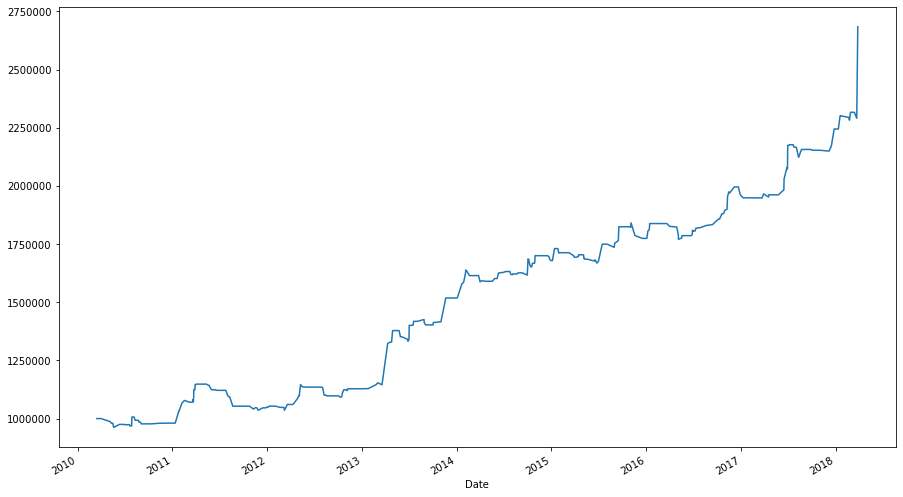

In [53]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

A more realistic portfolio that can invest in any in a list of twelve (tech) stocks has a final growth of about 100%. How good is this? While on the surface not bad, we will see we could have done better.

# Benchmarking
Backtesting is only part of evaluating the efficacy of a trading strategy. We would like to benchmark the strategy, or compare it to other available (usually well-known) strategies in order to determine how well we have done.

Whenever you evaluate a trading system, there is one strategy that you should always check, one that beats all but a handful of managed mutual funds and investment managers: buy and hold SPY. The efficient market hypothesis claims that it is all but impossible for anyone to beat the market. Thus, one should always buy an index fund that merely reflects the composition of the market.By buying and holding SPY, we are effectively trying to match our returns with the market rather than beat it.

I look at the profits for simply buying and holding SPY.

In [57]:
spyder = web.DataReader("SPY", "yahoo", start, end)
spyder = spyderdat
spyder.iloc[[0,-1],:]

High         Low        Open       Close       Volume  \
Date                                                                      
2016-01-04  201.029999  198.589996  200.490005  201.020004  222353500.0   
2020-02-24  333.559998  321.239990  323.140015  322.420013  160427500.0   

             Adj Close  
Date                    
2016-01-04  185.922073  
2020-02-24  322.420013

In [58]:
batches = 1000000 // np.ceil(100 * spyder.loc[:,"Adj Close"].iloc[0]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.loc[:,"Adj Close"].iloc[0] # How much money is used to buy SPY
final_val = batches * batch * spyder.loc[:,"Adj Close"].iloc[-1] + (1000000 - trade_val) # Final value of the portfolio
final_val

1723439.0823364258

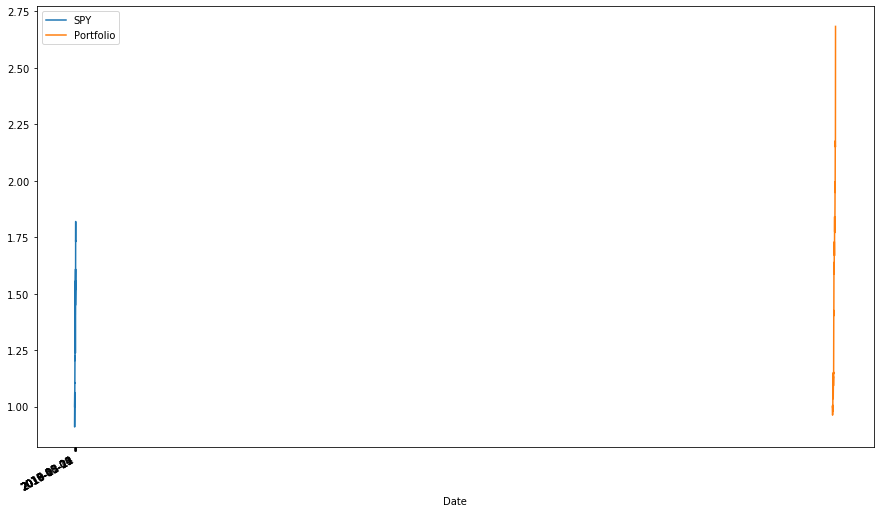

In [59]:
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"] / spyder.loc[:, "Adj Close"].iloc[0]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 1000000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench

Buying and holding SPY performs about as well as our trading system, at least how we currently set it up, and we haven’t even accounted for how expensive our more complex strategy is in terms of fees. Given both the opportunity cost and the expense associated with the active strategy, we should not use it.

What could we do to improve the performance of our system? For starters, we could try diversifying. All the stocks we considered were tech companies, which means that if the tech industry is doing poorly, our portfolio will reflect that. We could try developing a system that can also short stocks or bet bearishly, so we can take advantage of movement in any direction. We could seek means for forecasting how high we expect a stock to move. Whatever we do, though, must beat this benchmark; otherwise there is an opportunity cost associated with our trading system.

Other benchmark strategies exist, and if our trading system beat the “buy and hold SPY” strategy, we may check against them. Some such strategies include:

Buy SPY when its closing monthly price is aboves its ten-month moving average.
Buy SPY when its ten-month momentum is positive. (Momentum is the first difference of a moving average process, or MO^q_t = MA^q_t - MA^q_{t - 1}.)
(I first read of these strategies here.) The general lesson still holds: don’t use a complex trading system with lots of active trading when a simple strategy involving an index fund without frequent trading beats it. This is actually a very difficult requirement to meet.

As a final note, suppose that your trading system did manage to beat any baseline strategy thrown at it in backtesting. Does backtesting predict future performance? Not at all. Backtesting has a propensity for overfitting, so just because backtesting predicts high growth doesn’t mean that growth will hold in the future. There are strategies for combatting overfitting, such as walk-forward analysis and holding out a portion of a dataset (likely the most recent part) as a final test set to determine if a strategy is profitable, followed by “sitting on” a strategy that managed to survive these two filters and seeing if it remains profitable in current markets.

# Conclusion
While this lecture ends on a depressing note, keep in mind that the efficient market hypothesis has many critics. My own opinion is that as trading becomes more algorithmic, beating the market will become more difficult. That said, it may be possible to beat the market, even though mutual funds seem incapable of doing so (bear in mind, though, that part of the reason mutual funds perform so poorly is because of fees, which is not a concern for index funds).

This lecture is very brief, covering only one type of strategy: strategies based on moving averages. Many other trading signals exist and employed. Additionally, we never discussed in depth shorting stocks, currency trading, or stock options. Stock options, in particular, are a rich subject that offer many different ways to bet on the direction of a stock. You can read more about derivatives (including stock options and other derivatives) in the book Derivatives Analytics with Python: Data Analysis, Models, Simulation, Calibration and Hedging, which is available from the University of Utah library.

Another resource (which I used as a reference while writing this lecture) is the O’Reilly book Python for Finance, also available from the University of Utah library.

If you were interested in investigating algorithmic trading, where would you go from here? I would not recommend using the code I wrote above for backtesting; there are better packages for this task. Python has some libraries for algorithmic trading, such as pyfolio (for analytics), zipline (for backtesting and algorithmic trading), and backtrader (also for backtesting and trading). zipline seems to be popular likely because it is used and developed by quantopian, a “crowd-sourced hedge fund” that allows users to use their data for backtesting and even will license profitable strategies from their authors, giving them a cut of the profits. However, I prefer backtrader and have written blog posts on using it. It is likely the more complicated between the two but that’s the cost of greater power. I am a fan of its design. I also would suggest learning R, since it has many packages for analyzing financial data (moreso than Python) and it’s surprisingly easy to use R functions in Python (as I demonstrate in this post).

You can read more about using R and Python for finance on my blog.

Remember that it is possible (if not common) to lose money in the stock market. It’s also true, though, that it’s difficult to find returns like those found in stocks, and any investment strategy should take investing in it seriously. This lecture is intended to provide a starting point for evaluating stock trading and investments, and, more generally, analyzing temporal data, and I hope you continue to explore these ideas.

I have created a video course published by Packt Publishing entitled Training Your Systems with Python Statistical Modeling, the third volume in a four-volume set of video courses entitled, Taming Data with Python; Excelling as a Data Analyst. This course discusses how to use Python for machine learning. The course covers classical statistical methods, supervised learning including classification and regression, clustering, dimensionality reduction, and more! The course is peppered with examples demonstrating the techniques and software on real-world data and visuals to explain the concepts presented. Viewers get a hands-on experience using Python for machine learning. If you are starting out using Python for data analysis or know someone who is, please consider buying my course or at least spreading the word about it. You can buy the course directly or purchase a subscription to Mapt and watch it there.

If you like my blog and would like to support it, spread the word (if not get a copy yourself)! Also, stay tuned for future courses I publish with Packt at the Video Courses section of my site.